In [0]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report
from IPython import display
import pickle

In [0]:
! pip install -q scikit-plot
import scikitplot as skplt

In [0]:
batch_size = 300
epochs = 50
torch.manual_seed(1)
pre_epochs = 50

In [0]:
latent_dim = 100
class_dim = 16
N = 100

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [0]:
class GaussianNoise(nn.Module):

    def __init__(self, sigma=0.1, is_relative_detach=True):
        super().__init__()
        self.sigma = sigma
        self.is_relative_detach = is_relative_detach
        self.noise = torch.tensor(0).to(device)

    def forward(self, x):
        if self.training and self.sigma != 0:
            scale = self.sigma * x.detach() if self.is_relative_detach else self.sigma * x
            sampled_noise = self.noise.repeat(*x.size()).float().normal_() * scale
            x = x + sampled_noise
        return x 

In [0]:
class Gen(nn.Module):

  def __init__(self, latent_dim):
    super(Gen,self).__init__()

    self.arch = nn.Sequential(
        nn.Linear(latent_dim,500),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Linear(500,500),
        nn.BatchNorm1d(500, 0.8),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Linear(500, 28*28),
        nn.Sigmoid()
    )

  def forward(self, x):

    img = self.arch(x)
    img = img.view(x.shape[0],1,28,28)
    return img


In [0]:
class Disc(nn.Module):

  def __init__(self, class_latent):
    super(Disc,self).__init__()

    self.inpnoise = GaussianNoise(sigma=0.3)
    self.arch = nn.Sequential(
            nn.Linear( 28*28, 1000),
            nn.ReLU(),
            GaussianNoise(sigma=0.5),
            nn.Linear(1000, 500),
            nn.ReLU(),
            GaussianNoise(sigma=0.5),
            nn.Linear(500, 250),
            nn.ReLU(),
            GaussianNoise(sigma=0.5),
            nn.Linear(250, 250),
            nn.ReLU(),
            GaussianNoise(sigma=0.5),
            nn.Linear(250, 250),
            nn.ReLU(),
            GaussianNoise(sigma=0.5),
            nn.Linear(250, class_latent),
            nn.Sigmoid()
        )

  def forward(self, x):
    x = self.inpnoise(x)
    latent = self.arch(x)
    return latent

In [0]:
generator = Gen(latent_dim).to(device)
discriminator = Disc(class_dim).to(device)

In [0]:
optim_G = torch.optim.Adam(generator.parameters(), lr=0.003 , betas=(0.5, 0.999),weight_decay = 0.0001)
optim_D = torch.optim.Adam(discriminator.parameters(), lr=0.003, betas=(0.5, 0.999),weight_decay = 0.0001)

In [0]:
loss = torch.nn.BCELoss()

In [0]:
batches = len(train_loader)

# Pretraining GAN on Training Set

In [0]:
dloss=[]
gloss=[]
x = torch.randn((25,100),device=device)
for e in range(40):
  disc_loss = 0
  gen_loss = 0
  display.clear_output(wait=True)
  for i,(img,_) in enumerate(train_loader):

    discriminator.zero_grad()

    real = img.view(batch_size,28*28).to(device)
    valid = torch.full((batch_size,class_dim),1,device=device)
    fake = torch.full((batch_size,class_dim),0,device=device)

    output = discriminator(real)
    loss_r = loss(output,valid)
    loss_r.backward()

    noise = torch.randn(batch_size,latent_dim,device=device)
    gen = generator(noise)
    gen = gen.view(batch_size,28*28)
    output = discriminator(gen.detach())
    loss_f = loss(output,fake)
    loss_f.backward()

    loss_d = loss_r + loss_f
    disc_loss += loss_d
    optim_D.step()


    generator.zero_grad()

    output = discriminator(gen)
    loss_g = loss(output,valid)
    gen_loss += loss_g
    loss_g.backward()
    optim_G.step()
  
  disc_loss /= batches
  gen_loss /= batches
  dloss.append(disc_loss)
  gloss.append(gen_loss)

  print('Epoch : ',e," |  Disc. Loss : ",disc_loss.item()," |  Gen. Loss : ",gen_loss.item())

  with torch.no_grad():
    out = generator(x)
    out = out.detach().cpu().numpy()
    fig = plt.figure(figsize=(5,5))
    for i in range(25):
      plt.subplot(5, 5, i+1)
      plt.imshow(out[i].reshape(28,28),cmap='gray')
      plt.axis('off')
    plt.show()

KeyboardInterrupt: ignored

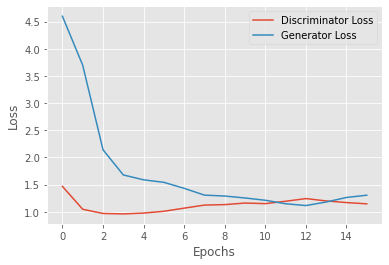

In [0]:
plt.style.use('ggplot')
plt.plot(dloss[:], label='Discriminator Loss')
plt.plot(gloss[:], label='Generator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [0]:
trainlatent = []
testlatent = []
with torch.no_grad():
  for i,(img,_) in enumerate(train_loader):

    img = img.view(img.shape[0],28*28).to(device)
    lat = discriminator(img).detach().cpu().numpy()
    trainlatent.append(lat)

  for i,(img,_) in enumerate(test_loader):

    img = img.view(img.shape[0],28*28).to(device)
    lat = discriminator(img).detach().cpu().numpy()
    testlatent.append(lat)

In [0]:
trainlatent = np.concatenate(trainlatent, axis=0)
testlatent = np.concatenate(testlatent, axis=0)

In [0]:
trainy = train_loader.dataset.targets.numpy()
testy = test_loader.dataset.targets.numpy()
trainlatent.shape,trainy.shape,testlatent.shape, testy.shape

((60000, 32), (60000,), (10000, 32), (10000,))

In [0]:
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(trainlatent,trainy)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                     weights='uniform')

In [0]:
knn.score(testlatent,testy)

0.1041

In [0]:
pred = knn.predict(testlatent)
print(classification_report(testy,pred))

              precision    recall  f1-score   support

           0       0.09      0.18      0.12       980
           1       0.12      0.18      0.14      1135
           2       0.11      0.14      0.12      1032
           3       0.12      0.13      0.12      1010
           4       0.09      0.08      0.09       982
           5       0.09      0.06      0.07       892
           6       0.10      0.08      0.09       958
           7       0.11      0.07      0.08      1028
           8       0.09      0.05      0.06       974
           9       0.12      0.06      0.08      1009

    accuracy                           0.10     10000
   macro avg       0.10      0.10      0.10     10000
weighted avg       0.10      0.10      0.10     10000



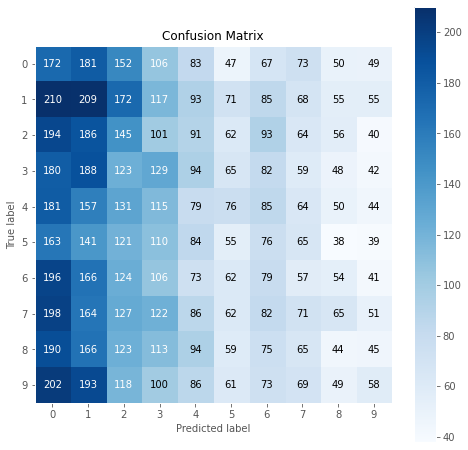

In [0]:
skplt.metrics.plot_confusion_matrix(testy, pred,figsize=(8,8))

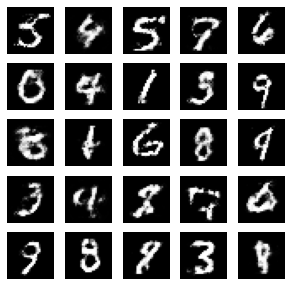

In [0]:
with torch.no_grad():
  x = torch.randn((25,100),device=device)
  out = generator(x)
  out = out.detach().cpu().numpy()
  fig = plt.figure(figsize=(5,5))
  for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(out[i].reshape(28,28),cmap='gray')
    plt.axis('off')
  plt.show()

In [0]:
with open('pregen32.model','wb') as f:
  pickle.dump(generator,f)
with open('predisc32.model','wb') as f:
  pickle.dump(discriminator,f)

/usr/local/lib/python3.6/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


# Training GAN on Triplets

In [0]:
with open('pregen.model','rb') as f:
  generator = pickle.load(f)
with open('predisc.model','rb') as f:
  discriminator = pickle.load(f)

In [0]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True),
    batch_size=1, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False),
    batch_size=1, shuffle=True, **kwargs)

In [0]:
optim_G = torch.optim.Adam(generator.parameters(), lr=0.00015 , betas=(0.5, 0.999))
optim_D = torch.optim.Adam(discriminator.parameters(), lr=0.00015, betas=(0.5, 0.999))

In [0]:
trainx = train_loader.dataset.data.numpy()
trainy = train_loader.dataset.targets.numpy()

In [0]:
trainx_unl = trainx.copy()
trainx_unl2 = trainx.copy()

In [0]:
batches = int(trainx.shape[0] / batch_size)

In [0]:
batches

200

In [0]:
inds = np.random.permutation(trainx.shape[0])

In [0]:
trainx = trainx[inds]
trainy = trainy[inds]

In [0]:
txs = []
tys = []
for j in range(10):
    txs.append(trainx[trainy==j][:int(N/10)])
    tys.append(trainy[trainy==j][:int(N/10)])
txs = np.concatenate(txs, axis=0)
tys = np.concatenate(tys, axis=0)

In [0]:
txs.shape , tys.shape

((100, 28, 28), (100,))

In [0]:
def triplet_loss(a,b,c):
  n_plus = F.pairwise_distance(a,b)
  n_minus = F.pairwise_distance(a,c)
  z = torch.cat((n_minus.view(batch_size,1),n_plus.view(batch_size,1)),0)
  z = torch.logsumexp(z,1)
  loss = torch.mean(z) - torch.mean(n_minus)
  return loss

In [0]:
loss_gen = torch.nn.MSELoss()

In [0]:
def get_triplets(prediction,size):
  a = prediction[0:size] # query case (positive)
  b = prediction[size:2*size] # positive case
  c = prediction[2*size:3*size] # negative

  return a,b,c

Epoch :  49  | Disc. Loss : 0.7835916876792908 Triplet Loss :  -0.6357951760292053  | Gen. Loss :  0.0018809930188581347


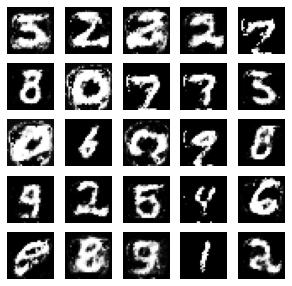

In [0]:
dlossarr = []
tlossarr = []
glossarr = []
for e in range(epochs):

  trainx = []
  trainy = []

  Pos = []
  Neg = []
  display.clear_output(wait=True)
  n_classes = np.unique(tys)

  for i in range(10):

    class_lab = n_classes[i]
    q_temp = txs[tys==class_lab]
    p_temp = txs[tys==class_lab]
    n_temp = txs[tys!=class_lab]

    for tp in range(10):
      for tn in range(txs.shape[0] - 10):
        trainx.append(q_temp)
        trainy.append(tys[tys==class_lab])
        Pos.append(np.roll(p_temp, tp, axis=0))
        Neg.append(np.roll(n_temp, tn, axis=0))
  
  trainx = np.concatenate(trainx, axis=0)
  trainy = np.concatenate(trainy, axis=0)
  Pos = np.concatenate(Pos, axis=0)
  Neg = np.concatenate(Neg, axis=0)
  inds = np.random.permutation(trainx.shape[0])
  inds = inds = inds[0:trainx_unl.shape[0]]

  trainx = trainx[inds]
  trainy= trainy[inds]
  Pos = Pos[inds]
  Neg = Neg[inds]

  trainx_unl = trainx_unl[np.random.permutation(trainx_unl.shape[0])]
  trainx_unl2 = trainx_unl2[np.random.permutation(trainx_unl2.shape[0])]

  disc_loss = 0
  gen_loss = 0
  trip_loss = 0

  
  for t in range(batches):

    discriminator.zero_grad()
    

    q = torch.from_numpy(trainx[t*batch_size:(t+1)*batch_size]).to(device).float()
    p = torch.from_numpy(Pos[t*batch_size:(t+1)*batch_size]).to(device).float()
    n = torch.from_numpy(Neg[t*batch_size:(t+1)*batch_size]).to(device).float()
    temptrain = torch.from_numpy(trainx_unl[t*batch_size:(t+1)*batch_size]).to(device).float()
    temptrain2 = torch.from_numpy(trainx_unl2[t*batch_size:(t+1)*batch_size]).to(device).float()

    trip_inp = torch.cat((q,p,n), axis = 0)

    disc_trip = discriminator(trip_inp.view(trip_inp.shape[0],28*28))
    gen_out = generator(torch.randn(batch_size, 100,device=device))
    disc_out_fake = discriminator(gen_out.view(batch_size,28*28).detach())
    disc_out_unl = discriminator(temptrain.view(batch_size,28*28))
    ql, pl, nl = get_triplets(disc_trip, batch_size)
    
    trploss = triplet_loss(ql, pl, nl)
    unlloss = loss(disc_out_unl, disc_out_fake.detach())

    dloss = unlloss + trploss
    
    dloss.backward()
    optim_D.step()
    
    generator.zero_grad()
    gen_out = generator(torch.randn(batch_size, 100,device=device))
    disc_out_fake = discriminator(gen_out.view(batch_size,28*28))
    disc_out_unl = discriminator(temptrain2.view(batch_size,28*28))
    gloss = loss_gen(disc_out_unl, disc_out_fake)

    gloss.backward()
    optim_G.step()
    
    disc_loss += unlloss
    gen_loss += gloss
    trip_loss += trploss

  disc_loss /= batches
  gen_loss /= batches
  trip_loss /= batches

  glossarr.append(gen_loss.item())
  dlossarr.append(disc_loss.item())
  tlossarr.append(trip_loss.item())

  print('Epoch : ', e, " | Disc. Loss :", disc_loss.item(),"Triplet Loss : ",trip_loss.item()," | Gen. Loss : ",gen_loss.item())

  with torch.no_grad():
    x = torch.randn((25,100),device=device)
    out = generator(x)
    out = out.detach().cpu().numpy()
    fig = plt.figure(figsize=(5,5))
    for i in range(25):
      plt.subplot(5, 5, i+1)
      plt.imshow(out[i].reshape(28,28),cmap='gray')
      plt.axis('off')
    plt.show()

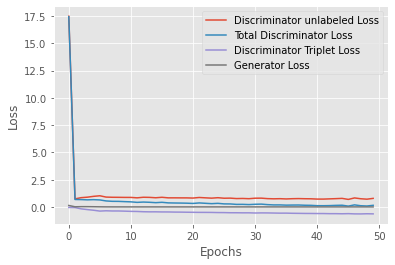

In [0]:
from operator import add 
dtot = list(map(add, dlossarr, tlossarr)) 

plt.style.use('ggplot')
plt.plot(dlossarr[:], label='Discriminator unlabeled Loss')
plt.plot(dtot[:], label = 'Total Discriminator Loss')
plt.plot(tlossarr[:], label='Discriminator Triplet Loss')
plt.plot(glossarr[:], label='Generator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [0]:
with open('disc32-100.model','rb') as f:
  discriminator = pickle.load(f)

In [0]:
kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

In [0]:
trainlatent = []
testlatent = []
with torch.no_grad():
  for i,(img,_) in enumerate(train_loader):

    img = img.view(img.shape[0],28*28).to(device)
    lat = discriminator(img).detach().cpu().numpy()
    trainlatent.append(lat)

  for i,(img,_) in enumerate(test_loader):

    img = img.view(img.shape[0],28*28).to(device)
    lat = discriminator(img).detach().cpu().numpy()
    testlatent.append(lat)

In [0]:
trainlatent = np.concatenate(trainlatent, axis=0)
testlatent = np.concatenate(testlatent, axis=0)

In [0]:
trainy = train_loader.dataset.targets.numpy()
testy = test_loader.dataset.targets.numpy()
trainlatent.shape,trainy.shape,testlatent.shape, testy.shape

((60000, 32), (60000,), (10000, 32), (10000,))

In [0]:
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(trainlatent,trainy)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                     weights='uniform')

In [0]:
knn.score(testlatent,testy)

In [0]:
pred = knn.predict(testlatent)
print(classification_report(testy,pred))

              precision    recall  f1-score   support

           0       0.14      0.00      0.01       980
           1       0.06      0.00      0.00      1135
           2       0.12      0.00      0.00      1032
           3       0.17      0.00      0.00      1010
           4       0.00      0.00      0.00       982
           5       0.08      0.00      0.00       892
           6       0.50      0.00      0.00       958
           7       0.10      0.99      0.19      1028
           8       0.00      0.00      0.00       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.10     10000
   macro avg       0.12      0.10      0.02     10000
weighted avg       0.12      0.10      0.02     10000



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


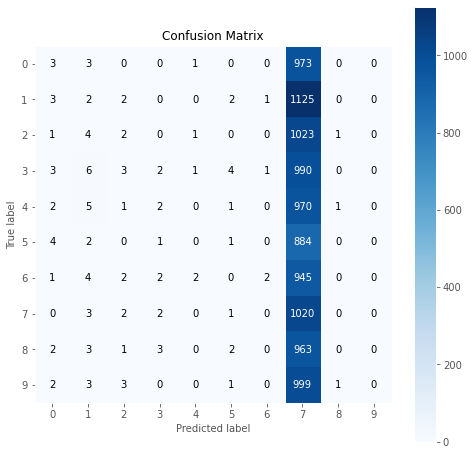

In [0]:
skplt.metrics.plot_confusion_matrix(testy, pred,figsize=(8,8))

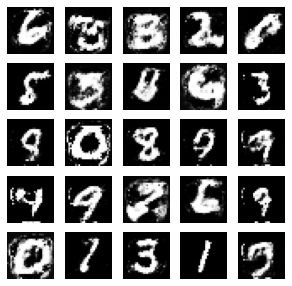

In [0]:
with torch.no_grad():
  x = torch.randn((25,100),device=device)
  out = generator(x)
  out = out.detach().cpu().numpy()
  fig = plt.figure(figsize=(5,5))
  for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(out[i].reshape(28,28),cmap='gray')
    plt.axis('off')

In [0]:
with open('disc16-200.model','wb') as f:
  pickle.dump(discriminator,f)

/usr/local/lib/python3.6/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


In [0]:
with open('disc32-100.model','rb') as f:
  disc = pickle.load(f)


In [0]:
torch.save(disc.state_dict(),'/content/drive/My Drive/DikshantSagar_2017338/weights_N_100_M_32.pt')